In [1]:
%matplotlib inline
import os, sys
%run prelims
import opc_python
import numpy as np
import matplotlib.pyplot as plt
import pandas
from opc_python.utils import loading, scoring
from opc_python.gerkin import dream,fit1,fit2,params

In [2]:
perceptual_headers, perceptual_obs_data = loading.load_perceptual_data('training')
all_CIDs = sorted(loading.get_CIDs('training')+loading.get_CIDs('leaderboard')+loading.get_CIDs('testset'))
mdx = dream.get_molecular_data(['dragon','episuite','morgan','nspdk','gramian'],all_CIDs)

Episuite has 62 features for 476 molecules.
Morgan has 2437 features for 476 molecules.
NSPDK has 6163 features for 476 molecules.
NSPDK Gramian has 2437 features for 476 molecules.
There are now 15969 total features.


### Create matrices

In [3]:
# Create the feature matrices from the feature dicts.  
X_training,good1,good2,means,stds,imputer = dream.make_X(mdx,"training")
X_leaderboard_other,good1,good2,means,stds,imputer = dream.make_X(mdx,"leaderboard",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_leaderboard_int,good1,good2,means,stds,imputer = dream.make_X(mdx,"leaderboard",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
X_testset_other,good1,good2,means,stds,imputer = dream.make_X(mdx,"testset",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_testset_int,good1,good2,means,stds,imputer = dream.make_X(mdx,"testset",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
X_all,good1,good2,means,stds,imputer = dream.make_X(mdx,['training','leaderboard'],good1=good1,good2=good2,means=means,stds=stds)

The X matrix now has shape (676x13914) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x13914) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x13914) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x13914) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x13914) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x13914) molecules by non-NaN good molecular descriptors


In [12]:
# Create descriptor matrices for the training set.  
# One is done with median imputation, and the other by masking missing values.  
Y_training_imp,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='median')
Y_training_mask,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='mask')

The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one for each subject


In [13]:
# Create descriptor matrices for the leaderboard set.  
# One is done with median imputation, and the other with no imputation 
Y_leaderboard,imputer = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer='mask')
Y_leaderboard_noimpute,_ = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer=None)

The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject


In [14]:
# Create descriptor matrices for the combined training and leaderboard sets.  
# One is done with median imputation, and the other by masking missing values.  
Y_all_imp,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='median')
Y_all_mask,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='mask')

The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


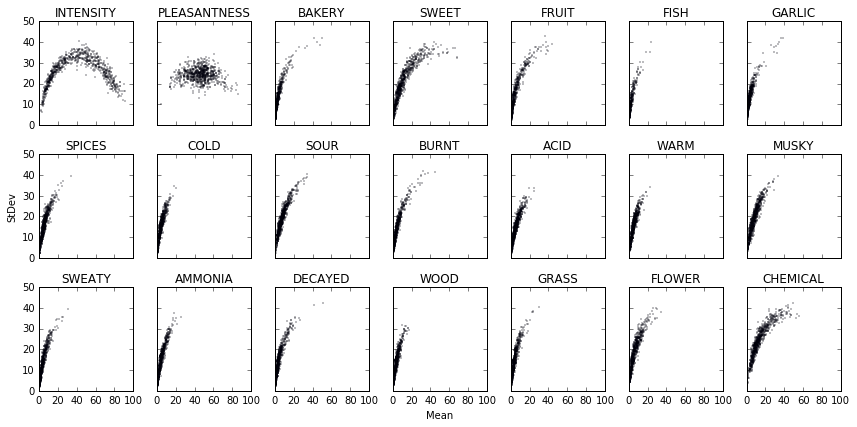

In [15]:
# Plot stdev vs mean for each descriptor, and fit to a theoretically-motivated function.  
# These fit parameters will be used in the final model fit.  
def f_transformation(x, k0=1.0, k1=1.0):
    return 100*(k0*(x/100)**(k1*0.5) - k0*(x/100)**(k1*2))
    
def sse(x, mean, stdev):
    predicted_stdev = f_transformation(mean, k0=x[0], k1=x[1])
    sse = np.sum((predicted_stdev - stdev)**2)
    return sse
    
fig,axes = plt.subplots(3,7,sharex=True,sharey=True,figsize=(12,6))
ax = axes.flat
trans_params = {col:None for col in range(21)}
from scipy.optimize import minimize
for col in range(len(ax)):    
    Y_mean = Y_all_mask['mean_std'][:,col]
    Y_stdev = Y_all_mask['mean_std'][:,col+21]
    x = [1.0,1.0]
    res = minimize(sse, x, args=(Y_mean,Y_stdev), method='L-BFGS-B')
    trans_params[col] = res.x # We will use these for our transformations.  
    ax[col].scatter(Y_mean,Y_stdev,s=0.1)
    x_ = np.linspace(0,100,100)
    #ax[col].plot(x_,f_transformation(x_, k0=res.x[0], k1=res.x[1]))
    ax[col].set_title(perceptual_headers[col+6].split('/')[1 if col==1 else 0])
    ax[col].set_xlim(0,100)
    ax[col].set_ylim(0,50)
    if col == 17:
        ax[col].set_xlabel('Mean')
    if col == 7:
        ax[col].set_ylabel('StDev')
plt.tight_layout()

In [16]:
# Load optimal parameters (obtained from extensive cross-validation).
cols = range(42)
def get_params(i):
    return {col:params.best[col][i] for col in cols}

use_et = get_params(0)
max_features = get_params(1)
max_depth = get_params(2)
min_samples_leaf = get_params(3)
trans_weight = get_params(4)
regularize = get_params(4)
use_mask = get_params(5)
for col in range(21):
    trans_weight[col] = trans_weight[col+21]

In [17]:
X_all_other,good1,good2,means,stds,imputer = dream.make_X(mdx,['training','leaderboard'],target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_all_int,good1,good2,means,stds,imputer = dream.make_X(mdx,['training','leaderboard'],target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)

The X matrix now has shape (407x13914) molecules by non-NaN good molecular descriptors
The X matrix now has shape (349x13914) molecules by non-NaN good molecular descriptors


In [26]:
from sklearn.cross_validation import ShuffleSplit
n_obs = int(len(Y_all_mask['mean_std'][:,col])/2)
n_splits = 15
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)
rs = np.zeros((42,n_splits))

X = X_all
Y = Y_all_mask['mean_std']
for k,(train,test) in enumerate(shuffle_split):
    print(k, flush=True)
    train = np.concatenate((2*train,2*train+1))
    test = np.concatenate((2*test,2*test+1))
    
    rfcs_cv,_,_ = fit2.rfc_final(X[train],Y_all_imp['mean_std'][train],
                                   Y[train],max_features,
                                   min_samples_leaf,max_depth,use_et,use_mask,
                                   trans_weight,trans_params,n_estimators=50,
                                   quiet=True)
    Y_cv = loading.make_prediction_files(rfcs_cv,X[test],X[test],
                                 'all',2,Y_test=None,
                                  write=False,trans_weight=trans_weight,
                                  trans_params=trans_params)
    for col in range(42):
        rs[col,k] = np.ma.corrcoef(Y_cv['mean_std'][:,col],
                                   Y[test,col])[0,1]
print(rs.mean(axis=1))

0
97.62% [------------------------------------------------- ]1
97.62% [------------------------------------------------- ]2
97.62% [------------------------------------------------- ]3
97.62% [------------------------------------------------- ]4
97.62% [------------------------------------------------- ]5
97.62% [------------------------------------------------- ]6
97.62% [------------------------------------------------- ]7
97.62% [------------------------------------------------- ]8
97.62% [------------------------------------------------- ]9
97.62% [------------------------------------------------- ]10
97.62% [------------------------------------------------- ]11
97.62% [------------------------------------------------- ]12
97.62% [------------------------------------------------- ]13
97.62% [------------------------------------------------- ]14
97.62% [------------------------------------------------- ][ 0.70429993  0.51384299  0.52884893  0.58728364  0.60348913  0.37946705
  0.500

In [32]:
best = np.array([.70429993,  0.51384299,  0.52884893,  0.58728364,  0.60348913,  0.37946705,
  0.5004598,   0.35897501,  0.31655091,  0.40376677,  0.42534259,  0.49363106,
  0.29386113,  0.31200202,  0.35080621,  0.37549074,  0.4347722,   0.25379221,
  0.35591619,  0.40667879,  0.6169039,   0.29508031,  0.09931859,  0.35694575,
  0.45563306,  0.52731457,  0.32835556,  0.4263107,   0.29301951,  0.287575,
  0.3756583,   0.3631568,   0.43923735,  0.22726946,  0.31959926,  0.32832815,
  0.36475936,  0.33911589,  0.24603573,  0.2765765,   0.35876195,  0.49759955])
best[0] = 0.75
best[1] = 0.70
best[2:21] *= 0.56/np.mean(best[2:21])
best[21] = 0.38
best[22] = 0.40
best[23:42] *= 0.50/np.mean(best[23:42])
best

array([ 0.75      ,  0.7       ,  0.7035416 ,  0.78127882,  0.80283741,
        0.50481496,  0.66577479,  0.47755387,  0.42111597,  0.53714152,
        0.5658444 ,  0.65669034,  0.39093117,  0.41506447,  0.4666867 ,
        0.49952518,  0.57838886,  0.33762643,  0.47348464,  0.54101546,
        0.82068343,  0.38      ,  0.4       ,  0.49785038,  0.63549459,
        0.73547243,  0.45797419,  0.5945972 ,  0.4086892 ,  0.40109547,
        0.52394973,  0.50651325,  0.61262666,  0.31698427,  0.44576133,
        0.45793596,  0.50874842,  0.47298217,  0.34315854,  0.3857553 ,
        0.50038353,  0.69402738])

In [25]:
from sklearn.cross_validation import ShuffleSplit
n_obs = int(len(Y_all_mask['subject'][1][:,col])/2)
n_splits = 3
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)
rs = np.zeros((21,49,n_splits))

X = X_all
Y = Y_all_mask['subject']
for k,(train,test) in enumerate(shuffle_split):
    print(k, flush=True)
    train = np.concatenate((2*train,2*train+1))
    test = np.concatenate((2*test,2*test+1))
    
    Y_train = {i:Y[i][train] for i in range(1,50)}
    Y_test = {i:Y[i][test] for i in range(1,50)}
    rfcs_cv,_,_ = fit1.rfc_final(X[train],Y_train,
                                 max_features,min_samples_leaf,max_depth,use_et,
                                 regularize=regularize,n_estimators=2)
    Y_cv = loading.make_prediction_files(rfcs_cv,X[test],X[test],
                                 'all',1,Y_test=None,
                                  write=False,regularize=regularize)
    for col in range(21):
        for subject in range(1,50):
            rs[col,subject-1,k] = np.ma.corrcoef(Y_cv['subject'][subject][:,col],
                                   Y_test[subject][:,col])[0,1]
print(rs.mean(axis=1))

0
4.00% [--                                                ]

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/sklearn/ensemble/forest.py:687: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [34]:
Y_all_mask,imputer = dream.make_Y_obs(['training','leaderboard'],
                                      target_dilution=None,imputer='mask')
y = np.ma.dstack([Y_all_mask['subject'][i] for i in range(1,50)])

The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


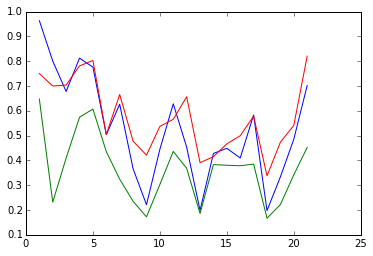

In [35]:
from sklearn.cross_validation import ShuffleSplit
n_splits = 100
rm = np.zeros((n_splits,21))
rs = np.zeros((n_splits,21))
shuff = ShuffleSplit(49,n_iter=n_splits,test_size=(24/49),random_state=0)
for col in range(21):
    for i,(a,b) in enumerate(shuff):
        ma = np.ma.mean(y[:,col,a],axis=1)
        mb = np.ma.mean(y[:,col,b],axis=1)
        sa = np.ma.std(y[:,col,a],axis=1)
        sb = np.ma.std(y[:,col,b],axis=1)
        rm[i,col] = np.corrcoef(ma,mb)[0,1]
        rs[i,col] = np.corrcoef(sa,sb)[0,1]
plt.plot(range(1,22),rm.mean(axis=0))
plt.plot(range(1,22),rs.mean(axis=0))
plt.plot(range(1,22),best[0:21],c='k')

In [37]:
best[21:]

array([ 0.38      ,  0.4       ,  0.49785038,  0.63549459,  0.73547243,
        0.45797419,  0.5945972 ,  0.4086892 ,  0.40109547,  0.52394973,
        0.50651325,  0.61262666,  0.31698427,  0.44576133,  0.45793596,
        0.50874842,  0.47298217,  0.34315854,  0.3857553 ,  0.50038353,
        0.69402738])

### Fitting and Generating Submission Files for challenge 2

In [36]:
# Fit training data.  
# Ignoring warning that arises if too few trees are used.  
# Ignore intensity score which is based on within-sample validation, 
# due to use of ExtraTreesClassifier.
n_estimators = 1000
rfcs_leaderboard,score,rs = fit2.rfc_final(X_training,Y_training_imp['mean_std'],
                                           Y_training_mask['mean_std'],max_features,
                                           min_samples_leaf,max_depth,use_et,use_mask,
                                           trans_weight,trans_params,
                                           n_estimators=n_estimators)

97.62% [------------------------------------------------- ]For subchallenge 2:
	Score = 9.71
	int_mean = 1.000
	int_sigma = 0.936
	ple_mean = 0.698
	ple_sigma = 0.240
	dec_mean = 0.516
	dec_sigma = 0.421


In [25]:
# Make challenge 2 leaderboard prediction files from the models.  
Y_pred = loading.make_prediction_files(rfcs_leaderboard,X_leaderboard_int,X_leaderboard_other,
                              'leaderboard',2,Y_test=Y_leaderboard_noimpute,
                              write=False,trans_weight=trans_weight,trans_params=trans_params)

Score: 8.961307; rs = 0.641,0.573,0.569,0.431,0.117,0.499
Wrote to file with suffix "1446422354"


{'mean_std': array([[ 71.70842857,  41.52902041,   2.94663288, ...,   8.73820076,
          13.5852291 ,  27.35685525],
        [ 59.89612245,  45.12281633,   1.75245157, ...,   9.3389807 ,
          15.71728531,  29.63782626],
        [ 20.93204082,  37.60470408,   1.84919165, ...,   7.97196496,
          10.26965993,  24.51386267],
        ..., 
        [ 34.5317551 ,  43.47964286,   1.83324128, ...,  15.72799914,
          16.31699961,  23.1197447 ],
        [ 40.23808163,  45.13152041,   2.66772469, ...,  10.2265469 ,
          20.67600147,  23.96670738],
        [ 32.96961224,  55.65241837,   2.02220511, ...,  25.55053778,
          18.88106105,  24.39162737]]), 'subject': {}}

In [26]:
# Fit all available data. 
# Ignoring warning that arises if too few trees are used.  
# Ignore intensity score which is based on within-sample validation, 
# due to use of ExtraTreesClassifier.
rfcs,score,rs = fit2.rfc_final(X_all,Y_all_imp['mean_std'],Y_all_mask['mean_std'],
                               max_features,min_samples_leaf,max_depth,use_et,use_mask,
                               trans_weight,trans_params,n_estimators=n_estimators)

97.62% [------------------------------------------------- ]For subchallenge 2:
	Score = 9.75
	int_mean = 1.000
	int_sigma = 0.938
	ple_mean = 0.700
	ple_sigma = 0.209
	dec_mean = 0.522
	dec_sigma = 0.427


In [27]:
# Make challenge 2 testset prediction files from the models.  
loading.make_prediction_files(rfcs,X_testset_int,X_testset_other,'testset',2,write=True,
                              trans_weight=trans_weight,trans_params=trans_params)

Wrote to file with suffix "1446435104"


{'mean_std': array([[ 21.89636735,  39.71637755,   1.90954771, ...,   9.98683842,
          10.47795684,  31.54727994],
        [ 27.75355102,  44.74494898,   2.07851814, ...,   8.11799799,
          10.28496659,  20.71858811],
        [ 59.63055102,  30.67554082,   1.8075775 , ...,   8.12056301,
          10.21969347,  25.82426989],
        ..., 
        [ 53.15091837,  51.24417347,   2.27342287, ...,  33.55969447,
          18.75528304,  20.69043221],
        [ 33.36522449,  49.04045918,   1.97972904, ...,  14.68861211,
          17.35520645,  23.22568437],
        [ 23.50810204,  49.45904082,   1.90788221, ...,  22.12489258,
          22.48449568,  33.0394573 ]]), 'subject': {}}

In [28]:
# Fit training data for subchallenge 1.  
# Ignoring warning that arises if too few trees are used.  
# Ignore intensity score which is based on within-sample validation, 
# due to use of ExtraTreesClassifier.
n_estimators = 50
rfcs_leaderboard,score,rs = fit1.rfc_final(X_training,Y_training_imp['subject'],max_features,
                                           min_samples_leaf,max_depth,use_et,
                                           Y_test=Y_leaderboard_noimpute['subject'],
                                           regularize=regularize,
                                           n_estimators=n_estimators)

98.00% [------------------------------------------------- ]For subchallenge 1:
	Score = 37.12
	int = 0.843
	ple = 0.402
	dec = 0.182


/anaconda/lib/python3.4/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


In [29]:
# Make challenge 1 leaderboard prediction files from the models.  
loading.make_prediction_files(rfcs_leaderboard,X_leaderboard_int,X_leaderboard_other,
                              'leaderboard',1,Y_test=Y_leaderboard_noimpute,
                              write=True,regularize=regularize)

Score: 27.753160; rs = 0.429,0.317,0.178
Wrote to file with suffix "1446474725"


{'subject': {1: array([[ 63.42269388,  43.78285714,   2.09603111, ...,   1.13950434,
            2.5056629 ,  13.40066528],
         [ 59.30073469,  45.47671429,   1.22167694, ...,   2.25695301,
            3.08044954,  14.100113  ],
         [ 23.14522449,  41.08514286,   1.45208672, ...,   1.35192001,
            1.79131942,   6.01025857],
         ..., 
         [ 32.31722449,  43.89757143,   1.51561664, ...,   3.6759995 ,
            4.28113598,   7.1933659 ],
         [ 39.77044898,  43.55385714,   4.83840181, ...,   2.96249798,
            7.16240494,  17.33127877],
         [ 42.22220408,  50.43414286,   2.24900751, ...,   8.99311304,
            5.69282902,  10.37460239]]),
  2: array([[ 65.46269388,  49.94485714,   2.65306529, ...,   1.0458901 ,
            2.51593386,  12.89772164],
         [ 62.24073469,  46.44571429,   1.28782724, ...,   2.26505963,
            3.12775306,  14.64866416],
         [ 28.37722449,  40.44614286,   1.63452993, ...,   1.35202984,
            1.8

In [30]:
# Fit all available data for subchallenge 1. 
# Ignoring warning that arises if too few trees are used.  
# Ignore intensity score which is based on within-sample validation, 
# due to use of ExtraTreesClassifier.
rfcs1,score1,rs1 = fit1.rfc_final(X_all,Y_all_imp['subject'],max_features,
                                           min_samples_leaf,max_depth,use_et,
                                           regularize=regularize,
                                           n_estimators=n_estimators)

98.00% [------------------------------------------------- ]For subchallenge 1:
	Score = 37.33
	int = 0.841
	ple = 0.406
	dec = 0.185


In [31]:
# Make challenge 1 testset prediction files from the models.  
loading.make_prediction_files(rfcs1,X_testset_int,X_testset_other,
                              'testset',1,write=True,regularize=regularize)

Wrote to file with suffix "1446510971"


{'subject': {1: array([[ 26.31755102,  40.149     ,   1.9511612 , ...,   2.10466287,
            2.68027593,  17.9639846 ],
         [ 22.36620408,  46.73742857,   1.46409153, ...,   1.03138155,
            1.93359848,   5.80899911],
         [ 53.568     ,  29.02685714,   1.27619873, ...,   1.14423211,
            2.04727742,   9.94377144],
         ..., 
         [ 52.10897959,  48.18242857,   3.53946303, ...,  11.14731045,
            5.74367517,   7.81414332],
         [ 24.75934694,  50.25014286,   1.38609663, ...,   4.98177721,
            4.33694397,  13.03485266],
         [ 29.72277551,  45.16628571,   1.9831435 , ...,   9.46573398,
            8.36780493,  23.16176282]]),
  2: array([[ 27.20155102,  40.206     ,   2.6977642 , ...,   2.10503145,
            2.50035918,  16.61862563],
         [ 21.21820408,  45.36342857,   1.59048489, ...,   1.03175554,
            1.90976702,   6.40190191],
         [ 57.84      ,  32.22785714,   1.33925015, ...,   1.14460611,
            2.0